# Steps and comments

Import functions from modules. "tool" is just name for now, I haven't found a good name for it yet.

**[functions](https://github.com/dkbrz/GSoC_2018/blob/master/tool/functions.py) **

**[evaluation](https://github.com/dkbrz/GSoC_2018/blob/master/tool/evaluation.py) **

In [1]:
from tool.functions import *
from tool.evaluation import *

**Dependencies**

Dependencies are written in file with functions

In [ ]:
import logging, sys, os, requests, json, re
from collections import Counter 
from math import exp, log10
from itertools import islice
import networkx as nx
import xml.etree.ElementTree as ET
from github import Github           #Github library for downloading dictionaries
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import matplotlib.pyplot as plt     #some evaluation (optional)
from heapdict import heapdict
from tqdm import tqdm_notebook as tqdm   #progress bar (I use notebook function because I work only here)
import random
import numpy as np, scipy.stats as st

## Loading dictionaries

Function creates a folder "dictionaries" and loads all bilingual dictionaries from Apertium Github. For now I delete ces-ces, ita-ita, eus-eu_bis, hbs_HR-hbs_SR, zh_CN-zh_TW manually, because these languages have to be somehow distinguished from each other. EPO-BEL has wrong name (inside it is bel-epo) so this have to be manually changed.

This function work about 20 min (?)

In [ ]:
%time download_all_bidixes()

This one creates artificially created monolingual dictionaries that contain all bilingual etries for a particular language.

3 min

In [ ]:
%time monodix()

In [ ]:
%time preprocessing()

Now we have all we need: dictionaries and some statistical information.

## Working with language pair

Set languages that we want to work with (order like in bidix name)

In [2]:
lang1, lang2 = 'eng','spa'
n = 10

Create a file "language_list" that contains languages we can use in graph in descending order (from more useful to less useful). 

Wall time: 805 ms


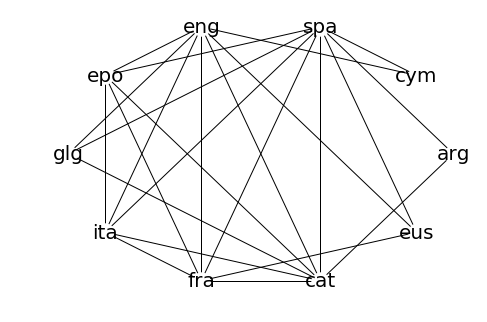

In [3]:
%time get_relevant_languages(lang1, lang2)
check_graph(lang1, lang2, n=n)

In [4]:
%time load_file(lang1, lang2, n=n)
%time change_encoding('{}-{}'.format(lang1,lang2))
%time G = built_from_file('{}-{}'.format(lang1,lang2))
%time l1, l2 = dictionaries(lang1, lang2)

Wall time: 904 ms
Wall time: 842 ms
Wall time: 1min 11s
Wall time: 5.52 s


If we want to check manually, we can search by lemma.

- G: graph
- 'star' : lemma
- l1 : source language dictionary
- 'spa' : target language name
- 4 : cutoff - maximum path length (otherwise search is very slow, this parameter should be equal (or +1) to maximum path length between languages in our top-10 languages)
- 40 : number of closest candidates to evaluate
- n=5 : how many candidates to print

In [5]:
%time print_lemma_results(lemma_search (G, 'star', l1, 'spa', 4, 40), n = 5)

		 eng$star$[n_n-ND]
spa$estrella$[n-f_n_n-f-sg]	1.73668185575284
spa$estelo$[n-m]	0.24433266990633906
spa$lucero$[n-m_n]	0.24433266990633906
spa$astro$[n_n-m]	0.15000141191914254
spa$estrella$[n-f-ND]	0.13358397513893056

		 eng$star$[adj]
spa$estelar$[adj_adj-mf]	0.13358397513893058
spa$estupendo$[adj-GD_adj-GD-ND]	0.006737946999085467
spa$magnífico$[adj_adj-GD-ND_adj-GD]	0.006737946999085467

		 eng$star$[vblex]
spa$protagonizar$[vblex]	0.3916487788905686
spa$jugar$[vblex_vblex-vbact]	0.2436094326405956
spa$presentar$[vblex]	0.09727280076923756
spa$constar$[vblex]	0.08379690677106663
spa$tocar$[vblex]	0.0404276819945128

Wall time: 247 ms


Search with larget cutoff takes a lot of time since we have to go furher and check all children in this subgraph

In [9]:
%time s = lemma_search (G, 'casa', l2, 'eng', 4, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 5, 40)
%time s = lemma_search (G, 'casa', l2, 'eng', 6, 40)

Wall time: 429 ms
Wall time: 1.57 s
Wall time: 8.26 s


## Evaluation

**How good is this instrument in translation prediction**

Loop does 1000 words (or less if dictionary is less than 1000) evaluation n_iter times to get more reliable result. It takes 1000 random words from first language that have only one translation and tries to find a translation without this edge between these two nodes. (But this node can have no neighbors except for this edge, so number can be lower)

- 'eng', 'spa' : languages
- n : top-n languages to include in graph
- n: how many iterations we do
- cutoff : max length path

Numbers in parentheses - the boundaries of the confidence interval

In [2]:
%time loop('eng', 'spa', n=10, cutoff=4, n_iter=10)


[0.6256240707628286, 0.6374282648229822, 0.632720098636314, 0.6409567308143358, 0.6145142860729746, 0.6339200666634857, 0.6450383346308625, 0.6553366983956048, 0.6299892904288924, 0.6368520536863447]
(0.6273379231913936, 0.6431380557915314)
Wall time: 8min 31s


**How many entries we can add**

Addition says how many entries we can add. (portion of all bilingual entries). I don't know how many make sense, but this number shows how many have at least one candidate (with this cutoff) for translation in other language. 

In [3]:
addition('eng', 'spa', n=10, cutoff=4)


Exist: 0.12212239152037098, failed: 0.07907419675389202, NEW: 0.06234266313348791, errors: 0.7364607485922491



Exist: 0.21855597332065632, failed: 0.4472895688376046, NEW: 0.13573044067015286, errors: 0.1984240171715862


English has 57 pairs so there could be a large variance in tags and entries. So this number can be explained.